In [9]:
# Importing relevant packages
import numpy as np
import pandas as pd
import os, sys
import pickle
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as stats

## path to the downloaded gutenberg corpus
path_gutenberg = os.path.join(os.pardir,os.pardir,'gutenberg')

## import internal helper functions
src_dir = os.path.join(os.pardir,'src')
sys.path.append(src_dir)

# Accessing the metadata
sys.path.append(os.path.join(path_gutenberg,'src'))
from metaquery import meta_query
mq = meta_query(path=os.path.join(path_gutenberg,'metadata','metadata.csv'), filter_exist=False)

In [10]:
###########
## Setup ##
###########
# number of pt for column in latex-document
fig_width_pt = 510  # single-column:510, double-column: 246; Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.1/72.27 # Convert pt to inches
width_vs_height = (np.sqrt(5)-1.0)/2.0 # Ratio of height/width [(np.sqrt(5)-1.0)/2.0]
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = width_vs_height*fig_width  # height in inches
fig_size = [fig_width,fig_height]

# here you can set the parameters of the plot (fontsizes,...) in pt
params = {'axes.titlesize':16,
          'axes.labelsize': 12,
          'legend.fontsize': 12,
          'xtick.labelsize': 12,
          'ytick.labelsize': 12,          
          'ps.usedistiller' : 'xpdf',
          'figure.figsize': fig_size,
          'xtick.direction':'out',
          'ytick.direction':'out',
          'axes.spines.right' : False,
          'axes.spines.top' : False
         }
plt.rcParams.update(params)

from matplotlib import rc
rc('text', usetex=True)

In [11]:
# Comparing results
# Columns: alpha=1, optimal alpha, jaccard, angular, manhattan, euclidean
def create_results_df(suffix):
    suffix_to_df = {'new_controlled':['controlled'], 'new':['uncontrolled']}

    dataframe_dict = {'controlled': suffix_to_df[suffix]*30,
                  'task' : ['author']*10 + ['subject']*10 + ['time period']*10 }
    model_name = 'all-MiniLM-L6-v2'

    # Extracting the alpba=1 and optimal alpha column
    alpha1 = []
    alpha_opt = []
    # alpha1_weights = []
    # alpha_opt_weights = []
    optimal_alphas = {'author':0.65, 'subject':0.6, 'time':0.8}
    opt_alpha_indexes = {'author':13, 'subject':12, 'time':16}

    for task in ['author', 'subject', 'time']:
        task_numbers = [i for i in range(11,21)]
        opt_alpha_index = opt_alpha_indexes[task]

        for num in task_numbers:
            input_file_path_opt_alpha = f'../output_files/optimal_alpha_{suffix}_{task}{num}.pickle'
            with open(input_file_path_opt_alpha, 'rb') as f:
                opt_alpha_results = pickle.load(f)
            
            # input_file_path_opt_alpha_weights = f'../output_files/optimal_alpha_weights_{task}{num}.pickle'
            # with open(input_file_path_opt_alpha_weights, 'rb') as f:
            #     opt_alpha_results_weights = pickle.load(f)
            
            alpha1.append(opt_alpha_results[20])
            alpha_opt.append(opt_alpha_results[opt_alpha_index])
            # alpha1_weights.append(round(opt_alpha_results_weights[20],2))
            # alpha_opt.append(round(max(opt_alpha_results_weights),2))

    dataframe_dict['alpha=1'] = alpha1
    dataframe_dict['best alpha'] = alpha_opt
    # dataframe_dict['alpha=1 (weights)'] = alpha1_weights
    # dataframe_dict['best alpha (weights)'] = alpha_opt_weights


    # Frequency results 
    for name in ['jaccard', 'overlap', 'euclidean_freq']:
        input_file_path_current = f'../output_files/{name}_results_new.pickle'
        with open(input_file_path_current, 'rb') as f:
            results_dict = pickle.load(f)
        all_results = []
        current_results = results_dict[suffix]
        for key in current_results:
            all_results += current_results[key]
        dataframe_dict[name] = all_results


    # Extracting the columns from embeddings
    for name in ['angular', 'manhattan', 'euclidean']:
        input_file_path_current = f'../output_files/{name}_embedding_results_new.pickle'
        with open(input_file_path_current, 'rb') as f:
            results_dict = pickle.load(f)
        all_results = []
        current_results = results_dict[suffix]
        for key in current_results:
            all_results += current_results[key]
        dataframe_dict[name] = all_results

    return pd.DataFrame(dataframe_dict)

# Displaying as a dataframe
# pd.concat([data1, data2], ignore_index=True, axis=0)
def concatenate_results_df():
    df1 = create_results_df('new_controlled')
    df2 = create_results_df('new')
    return pd.concat([df1, df2], ignore_index=True, axis=0)

## Figure 2

/var/folders/km/9ttg7bls33d_8n560hhmbnr00000gn/T/ipykernel_15747/2270636358.py:62: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


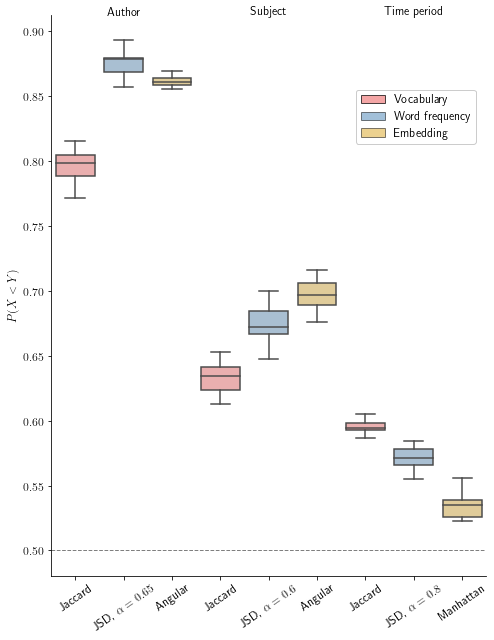

In [12]:
results = create_results_df('new')
long_df = pd.melt(results, id_vars = 'task', value_vars=['jaccard','overlap','alpha=1','best alpha','euclidean',
                                          'manhattan', 'angular'], var_name = 'metric', value_name='results')

task_vals = long_df['task']
metric_vals = long_df['metric']

task_metric = [f'{task_vals[i]}_{metric_vals[i]}' for i in range(len(task_vals)) ]

long_df['task_metric'] = task_metric

# Filter to ones we want
desired = ['author_jaccard', 'author_best alpha', 'author_angular',
           'subject_jaccard', 'subject_best alpha', 'subject_angular',
           'time period_jaccard', 'time period_best alpha', 'time period_manhattan']

filtered_df = long_df[long_df['task_metric'].isin(desired)]

fig, axes = plt.subplots(1,1,figsize=(7,9), tight_layout=True)

vocab_colour = 'lightcoral'
freq_colour = 'steelblue'
emb_colour = 'goldenrod'

axes.axhline(0.5, ls='--', lw=1, color='k', alpha=0.5)

colour_palettte = {'author_jaccard':vocab_colour, 'author_best alpha':freq_colour, 'author_angular':emb_colour,
                   'subject_jaccard':vocab_colour, 'subject_best alpha':freq_colour, 'subject_angular':emb_colour,
                   'time period_jaccard':vocab_colour, 'time period_best alpha':freq_colour, 'time period_manhattan':emb_colour}

sns.boxplot(y="results", x = 'task_metric', data=filtered_df, ax=axes, showfliers=False, order=desired, palette=colour_palettte)

i = 1
for patch in axes.patches:
      r, g, b, a = patch.get_facecolor()
      if i == 1 or i == 4 or i == 7:
            patch.set_facecolor((r, g, b, .7))
      else:
            patch.set_facecolor((r, g, b, .5))
      i += 1

axes.set_xticklabels([r'Jaccard', r'JSD, $\alpha = 0.65$', r'Angular',
                      r'Jaccard', r'JSD, $\alpha = 0.6$', r'Angular', 
                      r'Jaccard', r'JSD, $\alpha = 0.8$', r'Manhattan'], rotation=35)

axes.set(xlabel=None)
axes.set_ylabel(r'$P(X<Y)$')

legend_elements = [Patch(facecolor=vocab_colour, edgecolor='k',
                         label='Vocabulary', alpha=0.7),
                   Patch(facecolor=freq_colour, edgecolor='k',
                         label='Word frequency', alpha=0.5),
                   Patch(facecolor=emb_colour, edgecolor='k',
                         label='Embedding', alpha=0.5)]

axes.legend(handles=legend_elements, loc=(0.7,0.77),framealpha=1).get_frame().set_facecolor('w')

axes.annotate(r'Author',xy=(0.1285,1.0),xycoords = 'axes fraction', fontsize = 12)
axes.annotate(r'Subject',xy=(0.4575,1.0),xycoords = 'axes fraction', fontsize = 12)
axes.annotate(r'Time period',xy=(0.7655,1),xycoords = 'axes fraction', fontsize = 12)

fig.show()

# fig.savefig(f"../figures/all_boxplots.pdf")